<!-- impot libraries -->

In [258]:
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [259]:
MyDf = pd.read_csv("diabetes_prediction_dataset.csv")

In [260]:
MyDf

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [261]:
MyDf[MyDf['HbA1c_level'] > 6.5]['diabetes'].value_counts()

diabetes
0    7857
1    4578
Name: count, dtype: int64

In [262]:
MyDf.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [263]:
Numeric_DF = MyDf.drop(columns=['gender','smoking_history'], axis = 1)

<!-- Correlation between numerical features -->

In [264]:
corr_df = Numeric_DF.corr()
corr_df

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
age,1.000000,0.251171,0.233354,0.337396,0.101354,0.110672,0.258008
hypertension,0.251171,1.000000,0.121262,0.147666,0.080939,0.084429,0.197823
heart_disease,0.233354,0.121262,1.000000,0.061198,0.067589,0.070066,0.171727
bmi,0.337396,0.147666,0.061198,1.000000,0.082997,0.091261,0.214357
HbA1c_level,0.101354,0.080939,0.067589,0.082997,1.000000,0.166733,0.400660
blood_glucose_level,0.110672,0.084429,0.070066,0.091261,0.166733,1.000000,0.419558
diabetes,0.258008,0.197823,0.171727,0.214357,0.400660,0.419558,1.000000


<Axes: >

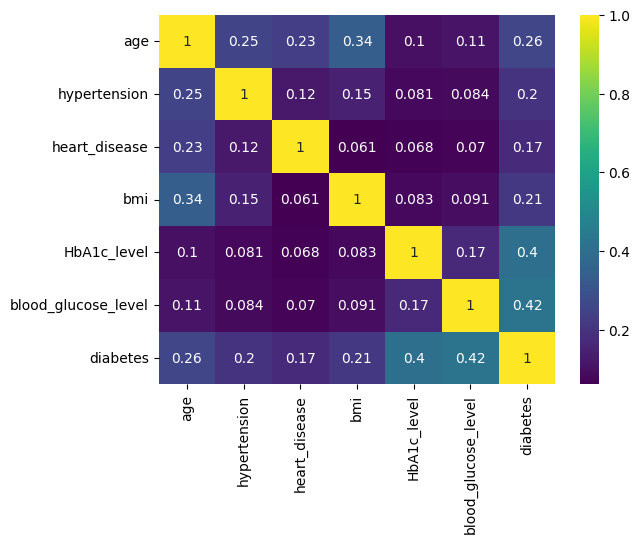

In [265]:
sns.heatmap(corr_df, annot = True, cmap = "viridis")

<!-- Feature engineering & Preprocessing -->

<!-- As it can be seen we do not have any null values in any coulmn -->

In [266]:
MyDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


<!-- Lable encoding the 'gender' column, since it's binary, we just give it 0/1 values  -->

In [267]:
MyDf['gender'] = LabelEncoder().fit_transform(MyDf['gender'])

In [268]:
MyDf['smoking_history'].value_counts() 

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

<!-- Since 'smoking_history' feature has multiple values, and it doesn't have a natural numeric order, one-hot coding would be the safest option -->

In [269]:
MyDf = pd.get_dummies(MyDf, columns=['smoking_history'], drop_first=True)


In [270]:
MyDf

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,0,80.0,0,1,25.19,6.6,140,0,False,False,False,True,False
1,0,54.0,0,0,27.32,6.6,80,0,False,False,False,False,False
2,1,28.0,0,0,27.32,5.7,158,0,False,False,False,True,False
3,0,36.0,0,0,23.45,5.0,155,0,True,False,False,False,False
4,1,76.0,1,1,20.14,4.8,155,0,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,80.0,0,0,27.32,6.2,90,0,False,False,False,False,False
99996,0,2.0,0,0,17.37,6.5,100,0,False,False,False,False,False
99997,1,66.0,0,0,27.83,5.7,155,0,False,False,True,False,False
99998,0,24.0,0,0,35.42,4.0,100,0,False,False,False,True,False


In [271]:
print(MyDf.columns.tolist())

['gender', 'age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes', 'smoking_history_current', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_not current']


In [272]:
X = MyDf.drop('diabetes' , axis = 1)
y = MyDf['diabetes']

In [273]:
X['smoking_history_current'] = X['smoking_history_current'].map({True: 1, False: 0})
X['smoking_history_ever'] = X['smoking_history_ever'].map({True: 1, False: 0})
X['smoking_history_former'] = X['smoking_history_former'].map({True: 1, False: 0})
X['smoking_history_never'] = X['smoking_history_never'].map({True: 1, False: 0})
X['smoking_history_not current'] = X['smoking_history_not current'].map({True: 1, False: 0})

Function for Normalizing

In [274]:
# this function is no longer used because it does not affect the model performance significantly (~0.3,0.4 % at best and sometimes it even worsens it)
# def normalize_features(X):
#    X = (X - X.mean()) / X.std()
#    return X

In [275]:
# X['bmi'] = normalize_features(X['bmi'])
# X['HbA1c_level'] = normalize_features(X['HbA1c_level'])
# X['blood_glucose_level'] = normalize_features(X['blood_glucose_level'])

In [276]:
# X = X.drop(columns=['HbA1c_level','blood_glucose_level'])

In [277]:
Iteration_num = 200

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 42)

In [279]:
model_xgboost = XGBClassifier(
    booster='dart',
    n_estimators = Iteration_num,
    learning_rate = 0.1,
    tree_method='approx',
    max_depth=15,
    reg_alpha=1,
    reg_lambda=1,
)

In [280]:
# Timer start
Start_time = time.time()

In [281]:
model_xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [282]:
y_pred = model_xgboost.predict(X_test)
y_pred_proba = model_xgboost.predict_proba(X_test)[:, 1]

In [283]:
# Timer end
End_time = time.time()

Function for calculating time, accuracy and classification report 

In [284]:
def Time_Accuracy(y_test, y_pred, y_pred_proba, Start_time, End_time):
    accuracy = accuracy_score(y_test,y_pred)
    execution_time = (End_time - Start_time)
    execution_time = round(execution_time, 3)
    roc = roc_auc_score(y_test, y_pred_proba)
    roc = round(roc, 3)
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc)
    print(f'Accuracy : {accuracy * 100:.2f} % \n')
    print("Training & Predicting time :",execution_time, "seconds")

In [285]:
Time_Accuracy(y_test, y_pred, y_pred_proba, Start_time, End_time)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.91      0.71      0.79      1700

    accuracy                           0.97     20000
   macro avg       0.94      0.85      0.89     20000
weighted avg       0.97      0.97      0.97     20000

ROC-AUC: 0.975
Accuracy : 96.88 % 

Training & Predicting time : 16.773 seconds


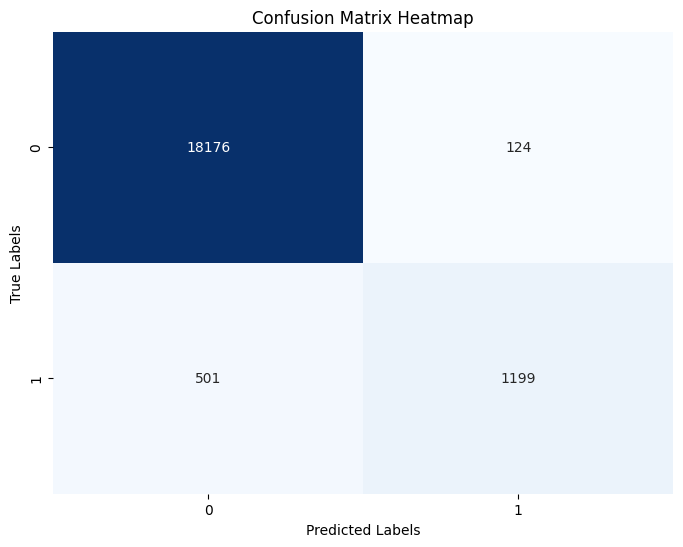

In [286]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels = MyDf['diabetes'].unique(), yticklabels = MyDf['diabetes'].unique())

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [287]:
importances = model_xgboost.get_booster().get_score(importance_type='gain')
df_importances = pd.DataFrame.from_dict(importances, orient='index', columns=['Importance'])
df_importances = df_importances.sort_values(by='Importance', ascending=False)

print(df_importances)


                             Importance
HbA1c_level                   12.201445
blood_glucose_level            6.719655
heart_disease                  1.748432
hypertension                   1.201097
age                            1.078196
bmi                            0.718331
smoking_history_ever           0.679199
smoking_history_not current    0.639598
smoking_history_current        0.559149
smoking_history_former         0.544899
smoking_history_never          0.528476
gender                         0.515095


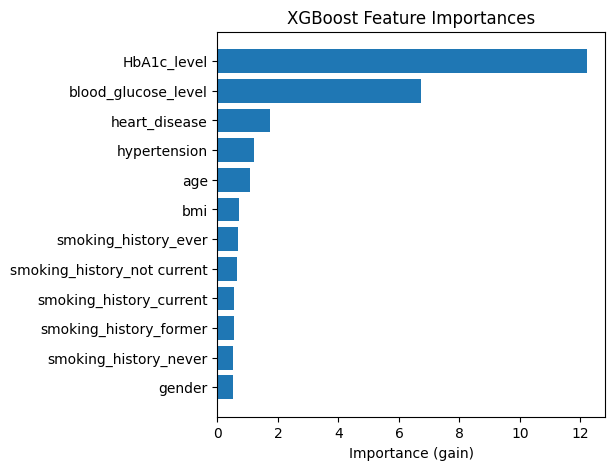

In [288]:
plt.figure(figsize=(5,5))
plt.barh(df_importances.index, df_importances['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Importance (gain)")
plt.title("XGBoost Feature Importances")
plt.show()


In [289]:
Start_time = time.time()

In [290]:
feature_importances = model_xgboost.feature_importances_
feature_importances = feature_importances/feature_importances.sum()

X_train_weighted = X_train * feature_importances
X_test_weighted = X_test * feature_importances

nn = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter = Iteration_num, random_state=42)
nn.fit(X_train_weighted, y_train)

MLPClassifier(hidden_layer_sizes=(32, 16), random_state=42)

In [291]:
y_nn_pred = nn.predict(X_test_weighted)
y_nn_pred_proba = nn.predict_proba(X_test_weighted)[:, 1]

In [292]:
End_time = time.time()

In [293]:
Time_Accuracy(y_test, y_nn_pred, y_nn_pred_proba, Start_time, End_time)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.97      0.69      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.97      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000

ROC-AUC: 0.977
Accuracy : 97.16 % 

Training & Predicting time : 28.8 seconds


<!-- Testing with the 2 most impactful features -->

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 42)

In [295]:
Start_time = time.time()

In [296]:
classifier = RandomForestClassifier(n_estimators = Iteration_num, random_state=42)
classifier.fit(X_train, y_train)
y_pred_RF = classifier.predict(X_test)
y_pred_proba_RF = classifier.predict_proba(X_test)[:, 1]

In [297]:
End_time = time.time()

In [298]:
Time_Accuracy(y_test, y_pred_RF, y_pred_proba_RF, Start_time, End_time)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.95      0.69      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.96      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000

ROC-AUC: 0.965
Accuracy : 97.02 % 

Training & Predicting time : 19.851 seconds


In [299]:
Start_time = time.time()

In [300]:
cat = CatBoostClassifier(
    iterations=Iteration_num,
    learning_rate=0.05,
    depth=6,
    eval_metric='Logloss',
    verbose=0,
    random_state=42
)
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)
y_pred_proba_cat = cat.predict_proba(X_test)[:, 1]

In [301]:
End_time = time.time()

In [302]:
Time_Accuracy(y_test, y_pred_cat, y_pred_proba_cat, Start_time, End_time)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18300
           1       0.98      0.69      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

ROC-AUC: 0.98
Accuracy : 97.22 % 

Training & Predicting time : 8.015 seconds


In [303]:
model_xgboost.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Stacking

In [304]:
# xgb_train_preds = model_xgboost.predict_proba(X_train)[:, 1].reshape(-1, 1)
# xgb_test_preds = model_xgboost.predict_proba(X_test)[:, 1].reshape(-1, 1)

# cat_train_preds = cat.predict_proba(X_train)[:, 1].reshape(-1, 1)
# cat_test_preds = cat.predict_proba(X_test)[:, 1].reshape(-1, 1)

In [305]:
# X_train_stacked = np.concatenate([X_train, xgb_train_preds, cat_train_preds], axis=1)
# X_test_stacked = np.concatenate([X_test, xgb_test_preds, cat_test_preds], axis=1)

In [306]:
# xgb_train_preds

In [312]:
Start_time = time.time()

In [ ]:
stack = StackingClassifier(
    estimators=[
        ('xgb', model_xgboost),
        ('cat', cat),
        ('rf', classifier)
    ],
    final_estimator=MLPClassifier(hidden_layer_sizes=(10,),
                                  activation='relu',
                                  solver='adam',
                                  max_iter=10,
                                  random_state=42),
    cv=5
)
stack.fit(X_train, y_train)

In [309]:
# nn = MLPClassifier(hidden_layer_sizes=(64, 32),
#                    activation='relu',
#                    solver='adam',
#                    max_iter=Iteration_num,
#                    random_state=42)

# nn.fit(X_train_stacked, y_train)

In [310]:
End_time = time.time()

In [311]:
y_pred = stack.predict(X_test)
y_pred_proba = stack.predict_proba(X_test)[:, 1]

In [257]:
Time_Accuracy(y_test, y_pred, y_pred_proba, Start_time, End_time)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.96      0.70      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.96      0.85      0.90     20000
weighted avg       0.97      0.97      0.97     20000

ROC-AUC: 0.98
Accuracy : 97.19 % 

Training & Predicting time : 250.217 seconds


In [187]:
X_important_features = X[['HbA1c_level','blood_glucose_level']]

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X_important_features, y, test_size = 0.2, stratify=y, random_state = 42)

In [189]:
# Timer start
Start_time = time.time()

In [190]:
model_xgboost.fit(X_train,y_train)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [191]:
y_pred = model_xgboost.predict(X_test)
y_pred_proba = model_xgboost.predict_proba(X_test)[:, 1]

In [192]:
# Timer end
End_time = time.time()

In [193]:
Time_Accuracy(y_test, y_pred, y_pred_proba, Start_time, End_time)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18300
           1       1.00      0.67      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000

ROC-AUC: 0.943
Accuracy : 97.23 % 

Training & Predicting time : 9.979 seconds


In [194]:
importances = model_xgboost.get_booster().get_score(importance_type='gain')
df_importances = pd.DataFrame.from_dict(importances, orient='index', columns=['Importance'])
df_importances = df_importances.sort_values(by='Importance', ascending=False)

print(df_importances)


                     Importance
HbA1c_level           65.061989
blood_glucose_level   39.121910


In [195]:
Start_time = time.time()

In [196]:
feature_importances = model_xgboost.feature_importances_
feature_importances = feature_importances/feature_importances.sum()

X_train_weighted = X_train * feature_importances
X_test_weighted = X_test * feature_importances

nn = MLPClassifier(hidden_layer_sizes=(32, 16), max_iter = Iteration_num, random_state=42)
nn.fit(X_train_weighted, y_train)

MLPClassifier(hidden_layer_sizes=(32, 16), random_state=42)

In [197]:
y_nn_pred = nn.predict(X_test_weighted)
y_nn_pred_proba = nn.predict_proba(X_test_weighted)[:, 1]

In [198]:
End_time = time.time()

In [199]:
Time_Accuracy(y_test, y_nn_pred, y_nn_pred_proba, Start_time, End_time)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18300
           1       1.00      0.58      0.74      1700

    accuracy                           0.96     20000
   macro avg       0.98      0.79      0.86     20000
weighted avg       0.97      0.96      0.96     20000

ROC-AUC: 0.929
Accuracy : 96.44 % 

Training & Predicting time : 11.86 seconds


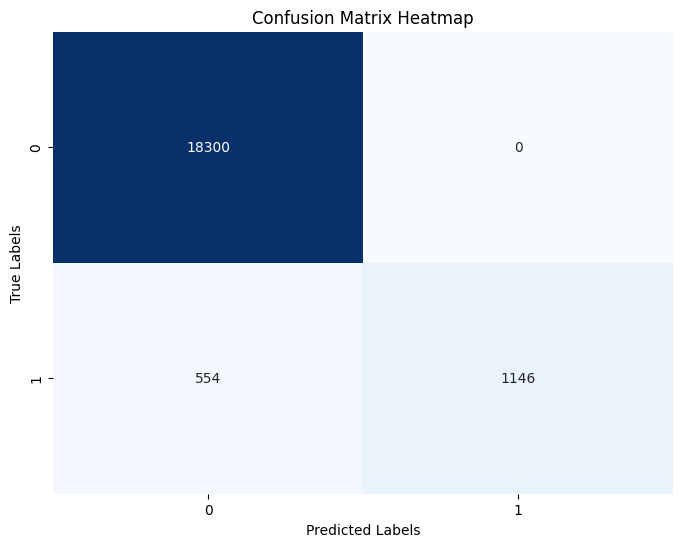

In [200]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels = MyDf['diabetes'].unique(), yticklabels = MyDf['diabetes'].unique())

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

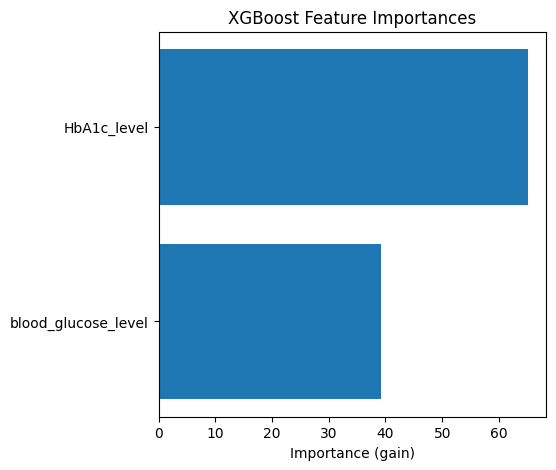

In [201]:
plt.figure(figsize=(5,5))
plt.barh(df_importances.index, df_importances['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Importance (gain)")
plt.title("XGBoost Feature Importances")
plt.show()
